# Notebook da Mega

Esse notebook trabalha com os dados públicos da Mega-Sena, disponíveis no  [Portal de Loterias da Caixa Econômica Federal][portal1].

Para a aquisição e análise dos dados, será utilizada a linguagem de programação Python e as bibliotecas Pandas, Numpy e Matplotlib, qGrid e Seaborn. Uma forma conveniente de instalar tudo o que é necessário para executar esse notebook é baixar o [Anaconda][anaconda1] da Continuum Analytics.

[portal1]: <http://loterias.caixa.gov.br/wps/portal/loterias/landing/megasena/> 
[anaconda1]: <https://www.continuum.io/downloads>

Antes de começar a trabalhar com os arquivos, vamos importar as bibliotecas que serão utilizadas, bem como inicializar configurações de ambiente.

In [105]:
import pandas as pd
import locale
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
sns.set(style="whitegrid")

import qgrid
qgrid.nbinstall(overwrite=True)
qgrid.set_defaults(remote_js=True, precision=4)

sns.set(style="whitegrid")
pal = sns.dark_palette("palegreen", as_cmap=True)

%matplotlib inline
#matplotlib.style.use('ggplot')

locale.setlocale(locale.LC_NUMERIC, 'Portuguese_Brazil.1252')

'Portuguese_Brazil.1252'

Para construir o dataset dessa notebook foi utilizado o arquivo disponibilizado pela Caixa Ecônomica Federal, disponível no endereço http://www1.caixa.gov.br/loterias/_arquivos/loterias/D_mgsasc.zip. Porém, esse arquivo não permite a importação de forma fácil dos dados.

Por esse motivo, gerei e vou utilizar um arquivo .CSV a partir do arquivo original. Hospedei ele no github para facilitar o nosso trabalho.

In [106]:
import urllib

urllib.urlretrieve("https://gist.githubusercontent.com/ikkebr/ce0b74f6d0dbf5a42015/raw/7f5120491feba60906946b56f5b88fb44382f11a/megasena.csv", "mega.csv")

('mega.csv', <httplib.HTTPMessage instance at 0x0000000054550748>)

Depois de obter o dataset, é necessário realizar a leitura do arquivo. A biblioteca Pandas possuí o método **read_csv** que permite a leitura de um arquivo CSV estruturado, de forma rápida e flexível.

O cabeçalho do arquivo indica as colunas disponíveis para nosso trabalho:

    Data;D1;D2;D3;D4;D5;D6;Arrecadacao_Total;Sena;Rateio_Sena;Quina;Rateio_Quina;Quadra;Rateio_Quadra;Acumulado;Valor_Acumulado
    
   

In [107]:
mega_results = pd.read_csv("mega.csv", sep=";",
                           engine='python', encoding='latin1',
                           parse_dates=['Data'], dayfirst=True,
                           infer_datetime_format=True)

Vamos começar calculando quantas vezes cada uma das dezenas já foi sorteada na megasena. Para isso, criaremos um subconjunto contendo as colunas referentes as dezenas sorteadas. 

Depois disso, achataremos essas colunas em um único vetor e utilizaremos o método **value_counts** de uma série de valores. Logo em seguida, converteremos o resultado desse calculo em um DataFrame.

Utilizaremos a biblioteca *Seaborn* para plotar o nosso gráfico de barras. No eixo Y iremos apresentar o número da dezena e no eixo X a quantidade de vezes que essa bolinha foi sorteada em algum concurso da Mega.



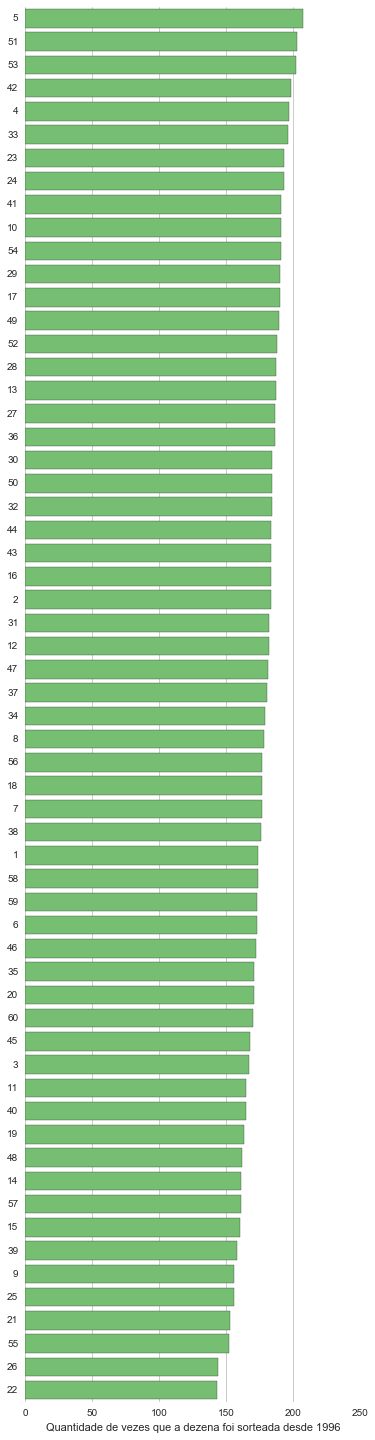

In [108]:
balls = mega_results[['D1','D2','D3','D4','D5','D6']]
balls_agg = pd.DataFrame( balls.values.flatten(), columns=['total'] )

balls_count = balls_agg['total'].value_counts(sort=True).to_frame().reset_index()


f, ax = plt.subplots(figsize=(6, 25))

sns.barplot(y="index", x="total", data=balls_count, label="Total", orient='h', color='g')


ax.set(xlim=(0, 250), ylabel="", xlabel="Quantidade de vezes que a dezena foi sorteada desde 1996")
sns.despine(left=True, bottom=True)

A contagem de quantas vezes cada dezena foi sorteada nos permite facilmente identificar que as dezenas 22, 26, 55, 21 e 25 são as dezenas menos sorteadas, enquanto as dezenas 5, 51, 53, 42 e 4 são as que sairam mais vezes.

Vamos calcular agora a quantidade de vezes que duas dezenas foram escolhidas no mesmo sorteio. Para isso utilizaremos a função *combinations* do módulo itertools da biblioteca padrão do Python e um *defaultdict* do módulo collections. 

Iremos iterar sobre o nosso subconjunto de resultados (que possui as colunas D1 .. D6 ), tomando os valores de dois a dois e incrementando no dicionário a contagem de vezes que a dupla aparece. PS. Como estamos utilizando combinations e nossos resultados estão ordenados, não é preciso se preocupar com chaves em posições diferentes, visto que nunca existirá a combinação (2,1) se existir a (1,2).

Depois da iteração, transformaremos nosso dicionário em um DataFrame com duas colunas (dezenas e total de vezes que aparece junto), para logo em seguida separar a coluna dezenas em D1 e D2 para facilitar o trabalho com os dados.

In [109]:
from itertools import combinations
from collections import defaultdict
pair_list = defaultdict(lambda: 0, [])
    
for values in balls.iterrows():
    for k in combinations(values[1], 2):
        pair_list[k] += 1
        #pair_list[k[::-1]] += 1
    
pairs = pd.DataFrame( list(pair_list.iteritems()), columns=['dezenas', 'total'] )

new_col_list = ['d1','d2']
for n,col in enumerate(new_col_list):
    pairs[col] = pairs['dezenas'].apply(lambda dezena: dezena[n])

Uma maneira interessante de observar as combinações entre duas dezenas sorteadas e a frequência com que essas dezenas são sorteadas juntas é utilizando um *heatmap*. Vamos utilizar o *Seaborn* para fazer isso. Quanto mais escuro no gráfico a combinação entre a dezena X e a dezena Y, maior o número de vezes que elas foram sorteadas junto.

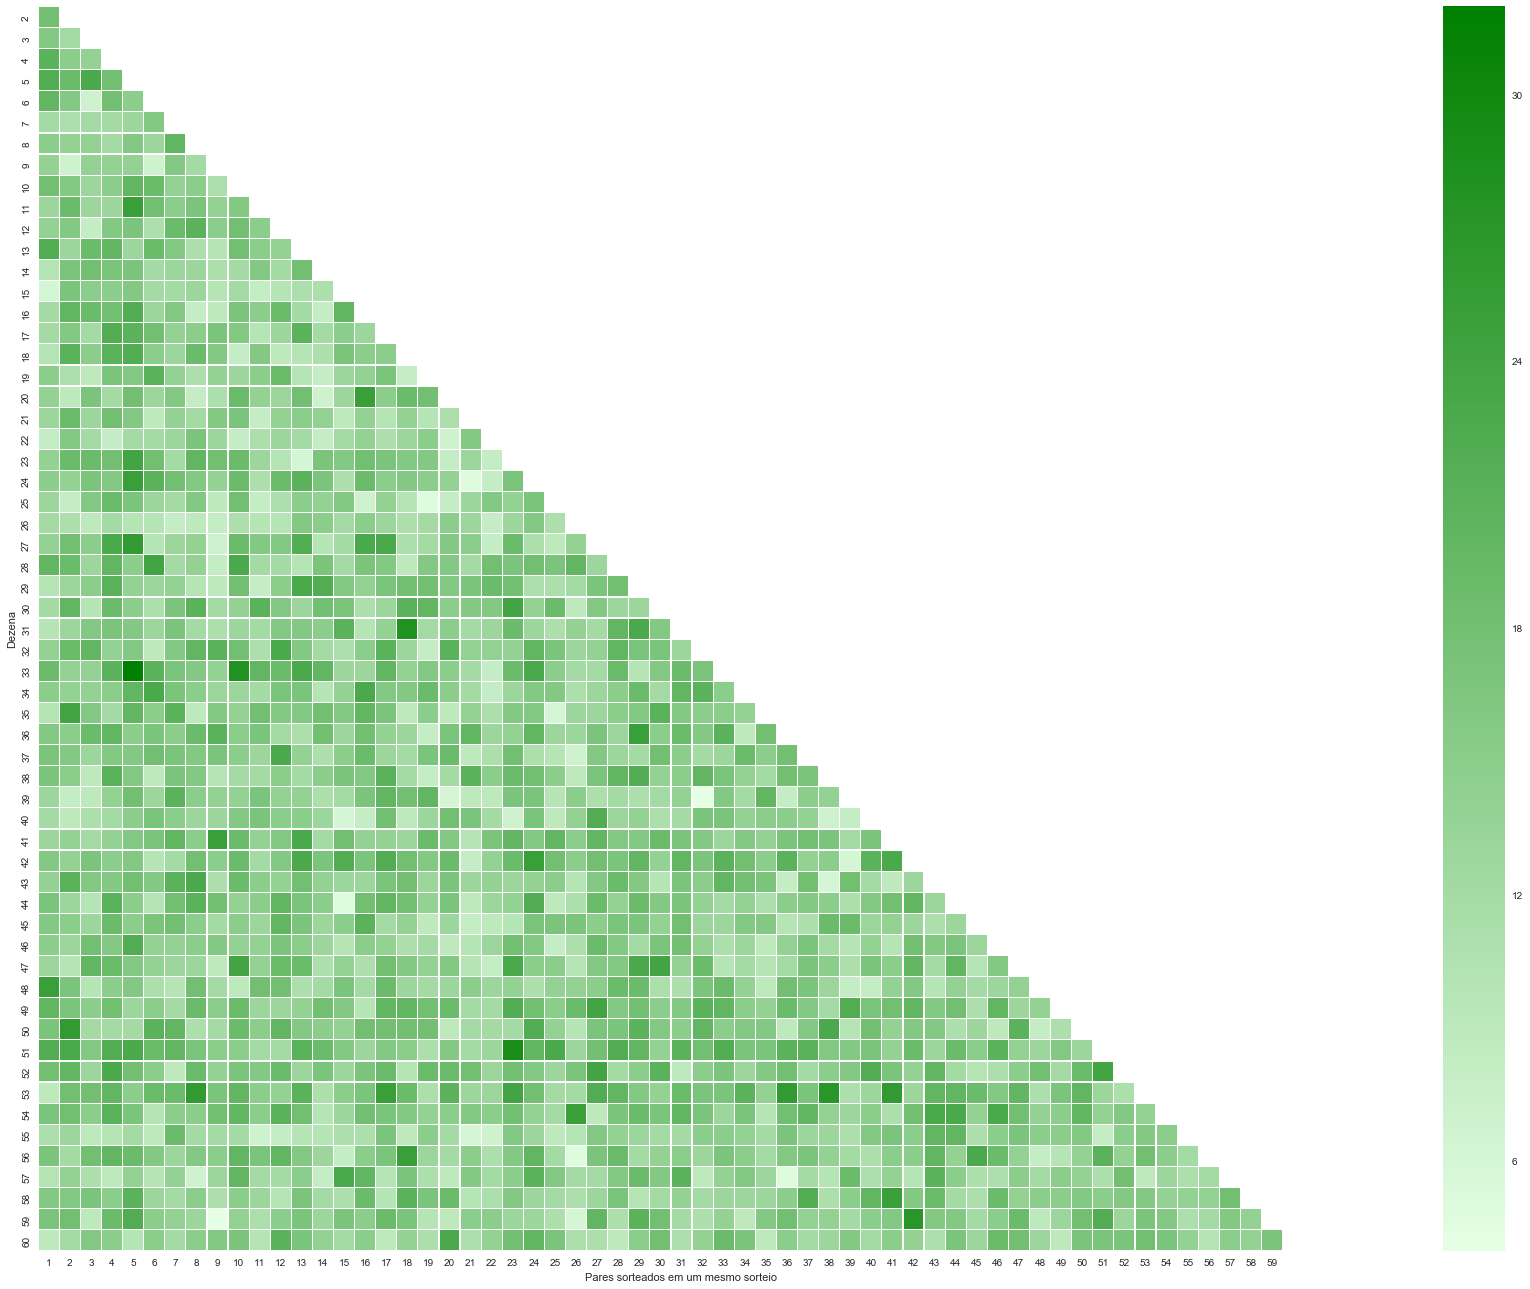

In [110]:
f, ax = plt.subplots(figsize=(33, 18))
pairs2 = pairs.pivot('d2','d1', 'total')
#pairs2.fillna(-1, inplace=True)
sns.color_palette("Paired")
sns.heatmap(pairs2, square=True, ax=ax, linewidths=.2, cmap=sns.light_palette("green", as_cmap=True))
ax.set(xlim=(0, 61), ylabel="Dezena", xlabel="Pares sorteados em um mesmo sorteio")
f.tight_layout()

As 20 combinações mais frequentes, agora no formato de lista:

In [111]:
pairs[['d1','d2','total']].sort_values('total', ascending=False)[:20]

,d1,d2,total
1596,5,33,32
227,23,51,29
412,10,33,28
909,18,31,28
129,38,53,27
823,42,59,27
1731,36,53,26
137,5,27,26
979,8,53,26
1134,2,50,26


Se desejarmos fazer a mesma coisa com trios de bolinhas sorteadas, a única coisa que devemos alterar é o agrupamento das combinações. Dessa vez, serão tomadas de 3 em 3.

In [112]:
trio_list = defaultdict(lambda: 0, [])
    
for values in balls.iterrows():
    for k in combinations(values[1], 3):
        trio_list[k] += 1
        #pair_list[k[::-1]] += 1


trios = pd.DataFrame( list(trio_list.iteritems()), columns=['dezenas', 'total'] )

new_col_list = ['d1','d2','d3']
for n,col in enumerate(new_col_list):
    trios[col] = trios['dezenas'].apply(lambda dezena: dezena[n])

Os 50 trios de dezenas que mais foram sorteados juntos até hoje:

In [113]:
trios[['d1','d2', 'd3', 'total']].sort_values('total', ascending=False)[:50]

,d1,d2,d3,total
12976,29,44,47,7
11654,2,18,30,7
16324,14,33,36,7
14595,21,30,52,7
11140,24,25,42,7
6217,29,38,50,7
10882,5,31,33,6
15944,1,51,59,6
19653,4,30,59,6
20321,2,30,52,6


Agora você deve estar se perguntando por quê eu fiz tudo isso? Simples. Nunca antes na história da Mega-sena ela pagou tanto quanto tem pago nos últimos anos. Em Dezembro de 2015, só em prêmios foram pagos quase R$620.000.000 (Seiscentos e vinte milhões de Reais).

Como eu sei isso? Para calcular o total de prêmios, precisamos somar o número de acertadores da Sena com o valor da Sena, o número de acertadores da Quina com o valor da Quina e o número de acertadores da Quadra com o valor do prêmio da Quadra em cada concurso. Para fazer isso, vamos criar uma coluna chamada Premios e realizar essas operações.

Mas não são só os prêmios que são altos na Mega. O valor arrecadado também é gigantesco e aumente a cada ano.

Em seguida vamos utilizar a Data dos sorteios e agrupar ela por mês. Para deixar nosso gráfico bonito, vamos escolher apenas os concursos dos quais nós temos os dados da arrecadação.

Primeiro vamos plotar o gráfico das arrecadações, em uma cor mais fraca, e depois vamos plotar o gráfico da premiação, em uma cor mais forte.


[<matplotlib.text.Text at 0x57ffbac8>, <matplotlib.text.Text at 0x3d37e198>]

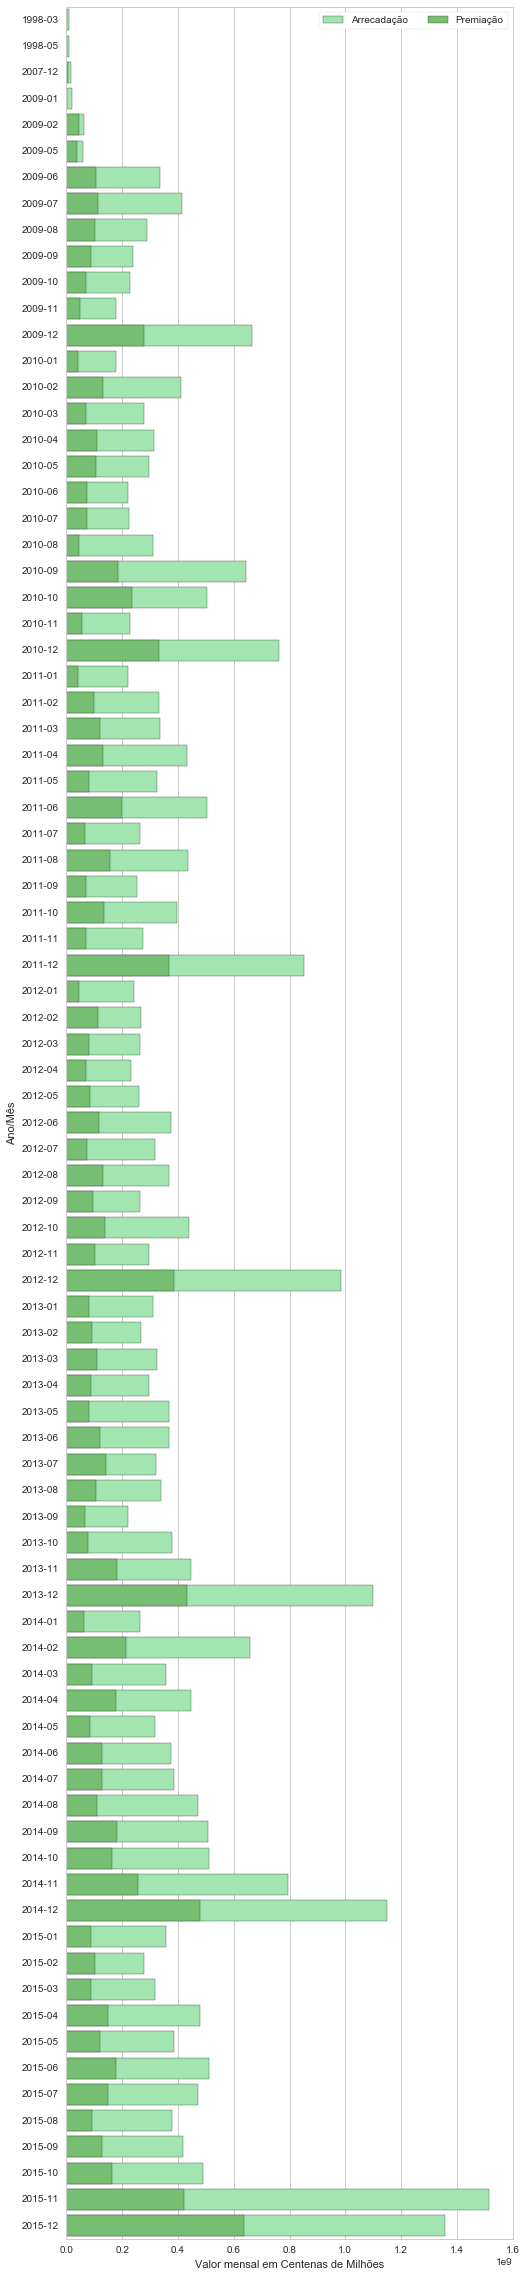

In [114]:
mega_results['Premios'] = mega_results['Sena'] * mega_results['Rateio_Sena'] + mega_results['Quina'] * mega_results['Rateio_Quina'] + mega_results['Quadra'] * mega_results['Rateio_Quadra']

f, ax = plt.subplots(figsize=(8, 40))

anos = mega_results[mega_results["Arrecadacao_Total"]> 0].groupby( mega_results.Data.dt.to_period("M") )

sns.set_color_codes("pastel")
sns.barplot(y='Data', x='Arrecadacao_Total', label=u"Arrecadação", data=anos['Arrecadacao_Total'].sum().reset_index(), color='g', orient='h' )

sns.set_color_codes("muted")
sns.barplot(y='Data', x='Premios', label=u"Premiação", data=anos['Premios'].sum().reset_index(), color='g', orient='h' )

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylabel=u"Ano/Mês", xlabel=u"Valor mensal em Centenas de Milhões")

Só nos dois últimos meses de 2015, a Mega arrecadou quase RS2.9 bilhões. E deu pouco mais de RS1.1 bilhão em prêmios. É a chance de muita gente ficar milionária.

Espero que tenha gostado da leitura. Se você tiver alguma crítica, ou sugestão, ou quiser entrar em contato comigo, mande um email para contato@henrique.email.

Se você gostou desse notebook, talvez esse aqui também possa te interessar: http://ikke.top/publico

**Publicado em Janeiro/2016**

